In [1]:
#!pip install hdbscan umap-learn

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan
import numpy as np
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# HDBSCAN

In [81]:
import warnings

def hdbscan_clustering_single_figure(datasets, min_cluster_size=5, min_samples=1, som_metric='euclidean', 
                                     min_variance=1e-6, pca_dim=None, silhouette_sample_size=5000,
                                     linkage_truncate=20, max_cols=3):
    """
    Run HDBSCAN on n-gram datasets:
      - df columns: 'ngram' + one column per virus type (counts)
      - Samples = n-grams, features = virus frequencies

    Visualization panels per dataset (3 columns):
      1. PCA scatter colored by cluster (without legend)
      2. Truncated single linkage tree
      3. Membership probabilities per point

    All datasets are arranged in a single figure grid (max_cols datasets per row).

    Optional parameters:
      - min_variance: remove virus-columns with near-zero variance
      - pca_dim: if set, reduce features to this dimension with PCA before HDBSCAN
      - silhouette_sample_size: number of samples to compute silhouette (None = all)
      - linkage_truncate: number of clusters to show in truncated single linkage tree
    """
    # Suppress all warnings temporarily
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        n_datasets = len(datasets)
        n_panels = 3  # PCA, Single linkage, Membership
        n_rows = math.ceil(n_datasets / max_cols)
        fig, axes = plt.subplots(n_rows, n_panels*max_cols, figsize=(6*max_cols, 5*n_rows))
        
        if n_rows == 1:
            axes = np.expand_dims(axes, axis=0)
        
        results = []

        for idx, (name, df) in enumerate(datasets.items()):
            # Clean
            if "Unnamed: 0" in df.columns:
                df = df.drop(columns=["Unnamed: 0"])
            if "ngram" not in df.columns:
                raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")

            virus_cols = [c for c in df.columns if c != "ngram"]
            X = df[virus_cols].values.astype(float)
            X = np.log1p(X)
            X = VarianceThreshold(threshold=min_variance).fit_transform(X)

            # Remove duplicates
            n_before = X.shape[0]
            X = np.unique(X, axis=0)
            n_after = X.shape[0]
            n_duplicates = n_before - n_after
            if n_duplicates > 0:
                print(f"{n_duplicates} duplicate rows removed from {name}")

            Xs = StandardScaler().fit_transform(X)
            if pca_dim is not None and pca_dim < Xs.shape[1]:
                Xs = PCA(n_components=pca_dim, random_state=42).fit_transform(Xs)

            model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    metric=som_metric)
            labels_pred = model.fit_predict(Xs)

            n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
            n_noise = int(np.sum(labels_pred == -1))
            mask = labels_pred != -1
            silhouette = None
            if n_clusters > 1 and np.any(mask) and len(set(labels_pred[mask])) > 1:
                try:
                    silhouette = float(silhouette_score(
                        Xs[mask], labels_pred[mask],
                        sample_size=min(silhouette_sample_size, np.sum(mask)),
                        random_state=42
                    ))
                except Exception:
                    silhouette = None

            results.append({
                "n_gram": name,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "silhouette_score": silhouette
            })

            # PCA 2D for plotting
            pca_result = PCA(n_components=2, random_state=42).fit_transform(Xs)

            # Odredi poziciju u mreži
            row_idx = idx // max_cols
            col_idx = idx % max_cols
            start_col = col_idx * n_panels
            ax0 = axes[row_idx, start_col]
            ax1 = axes[row_idx, start_col+1]
            ax2 = axes[row_idx, start_col+2]

            # Panel 1: PCA scatter
            unique_labels = np.unique(labels_pred)
            n_labels = len(unique_labels)
            cmap = plt.get_cmap("tab20", n_labels)
            for lbl in unique_labels:
                mask_lbl = labels_pred == lbl
                ax0.scatter(pca_result[mask_lbl,0], pca_result[mask_lbl,1],
                            c=[cmap(lbl if lbl >= 0 else n_labels)]*np.sum(mask_lbl),
                            s=15, edgecolor='none', alpha=0.6)
            ax0.set_title(f"PCA ({name})")
            ax0.set_xlabel("PCA 1")
            ax0.set_ylabel("PCA 2")

            # Panel 2: Single linkage tree
            plt.sca(ax1)
            if hasattr(model, 'single_linkage_tree_'):
                model.single_linkage_tree_.plot(truncate_mode='lastp', p=linkage_truncate,
                                                cmap='viridis', colorbar=True)
            ax1.set_title(f"Single Linkage ({name})")

            # Panel 3: Membership probabilities
            sc = ax2.scatter(pca_result[:,0], pca_result[:,1],
                             c=model.probabilities_, cmap='viridis', s=15, edgecolor='none', alpha=0.7)
            ax2.set_title(f"Membership ({name})")
            ax2.set_xlabel("PCA 1")
            ax2.set_ylabel("PCA 2")
            plt.colorbar(sc, ax=ax2, label="Cluster Membership Probability")

        plt.tight_layout()
        plt.show()
        results_df = pd.DataFrame(results)
        print(results_df)
        return results_df

In [82]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

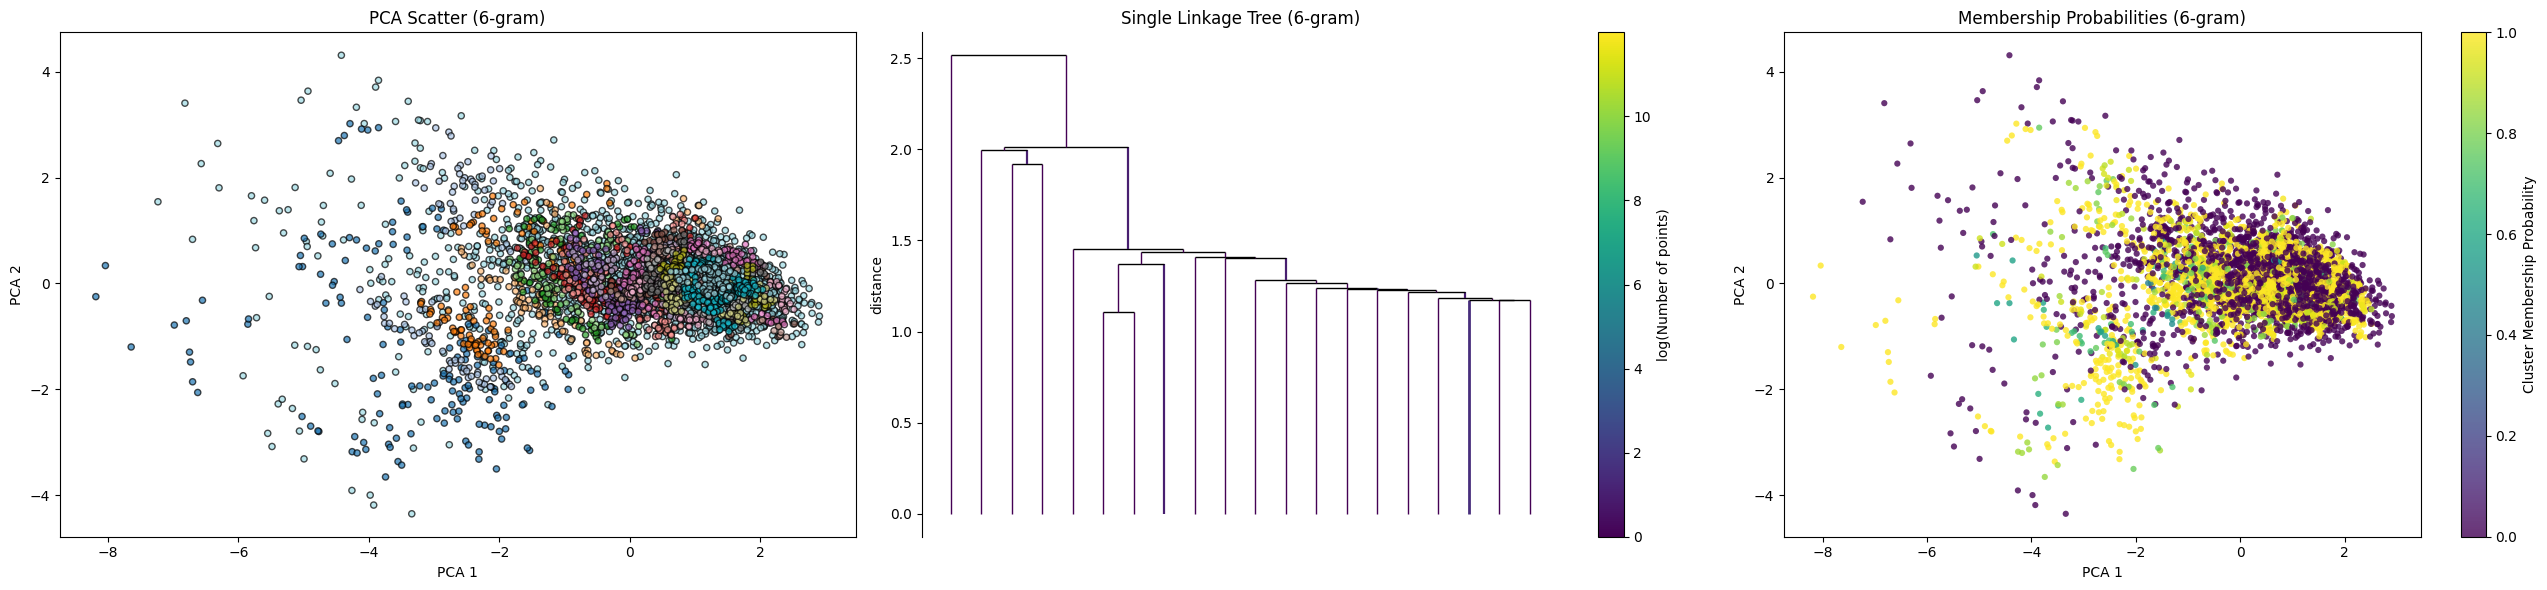

/tmp/ipykernel_4022/787750357.py:56: UserWarning: 122 duplicate rows removed from 7-gram
  warnings.warn(f"{n_before - n_after} duplicate rows removed from {name}")


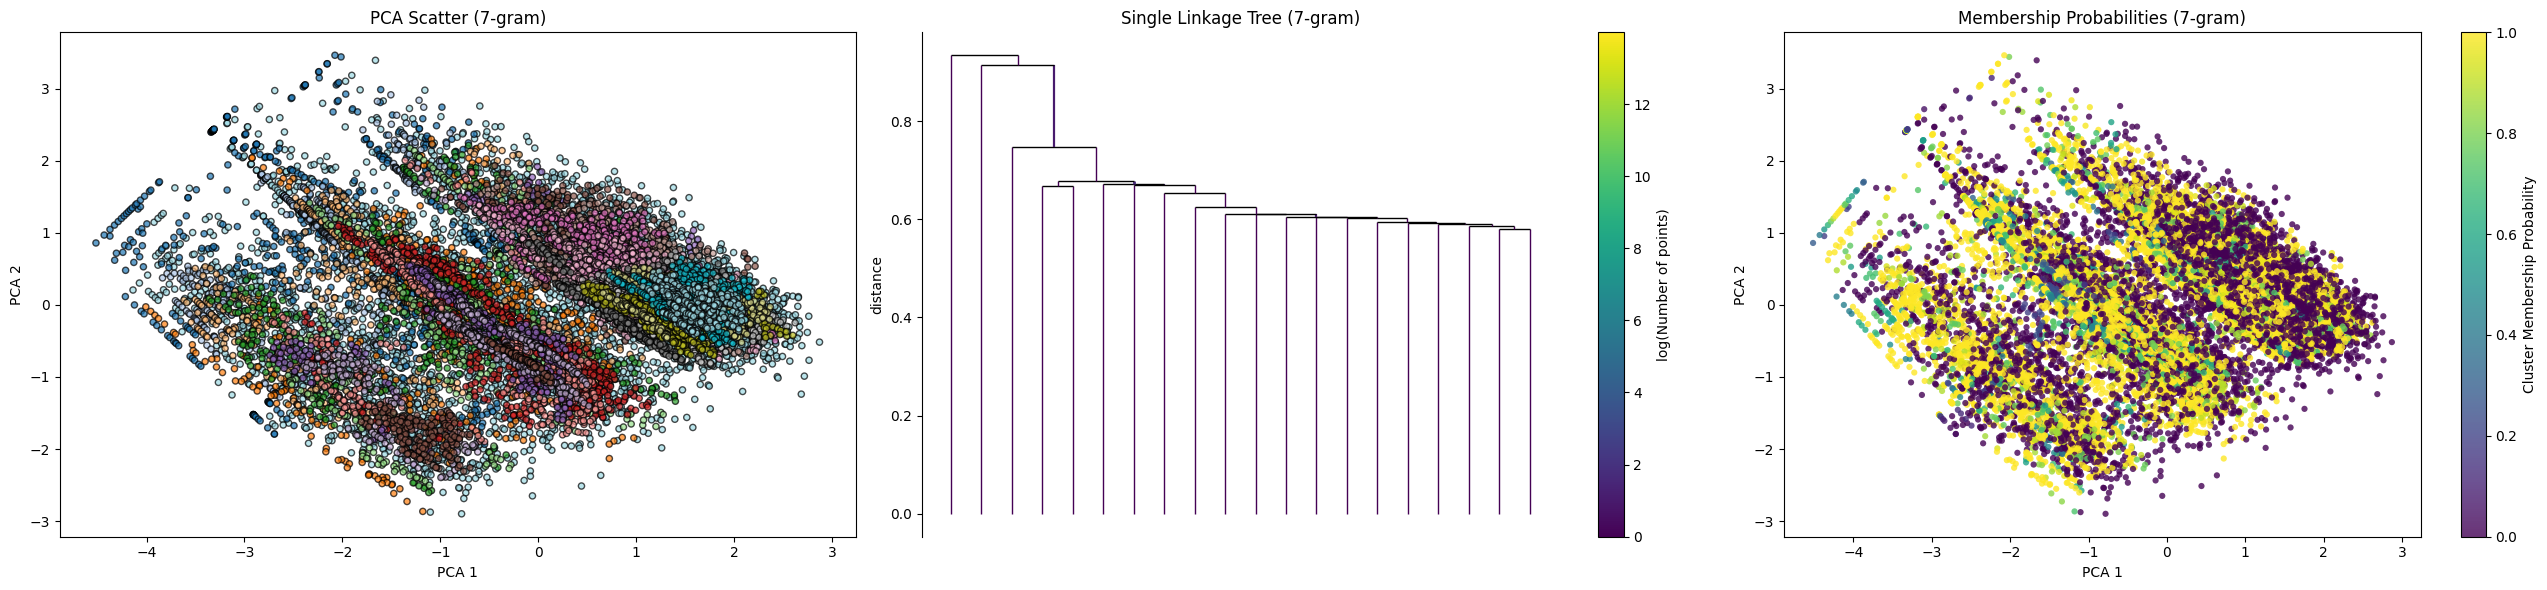

/tmp/ipykernel_4022/787750357.py:56: UserWarning: 17802 duplicate rows removed from 8-gram
  warnings.warn(f"{n_before - n_after} duplicate rows removed from {name}")


In [ ]:

results_df = hdbscan_clustering(datasets, pca_dim=10, silhouette_sample_size=5000)

PROBA

#  Hierarchical Clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [21]:
def hierarchical_clustering(datasets, cluster_range=range(2, 11), pca_dim=None):
    """
    AgglomerativeClustering over a range of cluster counts (k) for each dataset,
    with automatic PCA reduction if needed.

    Expected df shape per dataset: ['ngram', <virus_1>, <virus_2>, ...]
      - Transpose so that samples = virus types (rows), features = n-grams (columns)
      - Standardize features prior to clustering
      - PCA optional to reduce high-dimensional n-gram matrices

    Returns:
      results: dict {dataset_name: {"clusters": [...], "silhouette": [...], "calinski": [...], "davies": [...]}}

    Also plots metric curves (Silhouette, Calinski-Harabasz, Davies-Bouldin) per dataset.
    """
    results = {name: {"clusters": [], "silhouette": [], "calinski": [], "davies": []}
               for name in datasets}

    prepared = {}
    for name, df in datasets.items():
        # Clean dataframe
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")

        mat = df.set_index("ngram").T  # rows = virus types (samples), cols = n-grams (features)
        X = mat.values.astype(float)

        # PCA if requested or if features > samples
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        n_samples, n_features = Xs.shape
        if pca_dim is None:
            target_dim = min(n_samples, n_features)
        else:
            target_dim = min(pca_dim, n_samples, n_features)

        if target_dim < n_features:
            Xs = PCA(n_components=target_dim, random_state=42).fit_transform(Xs)

        prepared[name] = Xs

    # Grid search over k
    for name, Xs in prepared.items():
        n_samples = Xs.shape[0]
        for k in cluster_range:
            if k > n_samples:
                # Skip k larger than number of samples
                continue

            from sklearn.cluster import AgglomerativeClustering
            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
            labels = model.fit_predict(Xs)

            # Metrics
            from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

            # Silhouette only valid if 2 <= k <= n_samples - 1
            sil = None
            if 1 < k < n_samples:
                try:
                    sil = silhouette_score(Xs, labels)
                except Exception:
                    sil = None

            # Calinski and Davies-Bouldin can work for k <= n_samples
            cal = None
            try:
                cal = calinski_harabasz_score(Xs, labels)
            except Exception:
                cal = None

            dav = None
            try:
                dav = davies_bouldin_score(Xs, labels)
            except Exception:
                dav = None

            results[name]["clusters"].append(k)
            results[name]["silhouette"].append(sil)
            results[name]["calinski"].append(cal)
            results[name]["davies"].append(dav)

    # Plot per dataset
    n_sets = len(datasets)
    fig, axes = plt.subplots(n_sets, 3, figsize=(18, 4 * n_sets))
    if n_sets == 1:
        axes = np.expand_dims(axes, axis=0)

    metrics = [("silhouette", "Silhouette"), ("calinski", "Calinski-Harabasz"), ("davies", "Davies-Bouldin")]
    for i, (name, scores) in enumerate(results.items()):
        for j, (key, title) in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(scores["clusters"], scores[key], marker='o')
            ax.set_title(f"{name} — {title}")
            ax.set_xlabel("Number of clusters (k)")
            ax.set_ylabel(title)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results


In [15]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

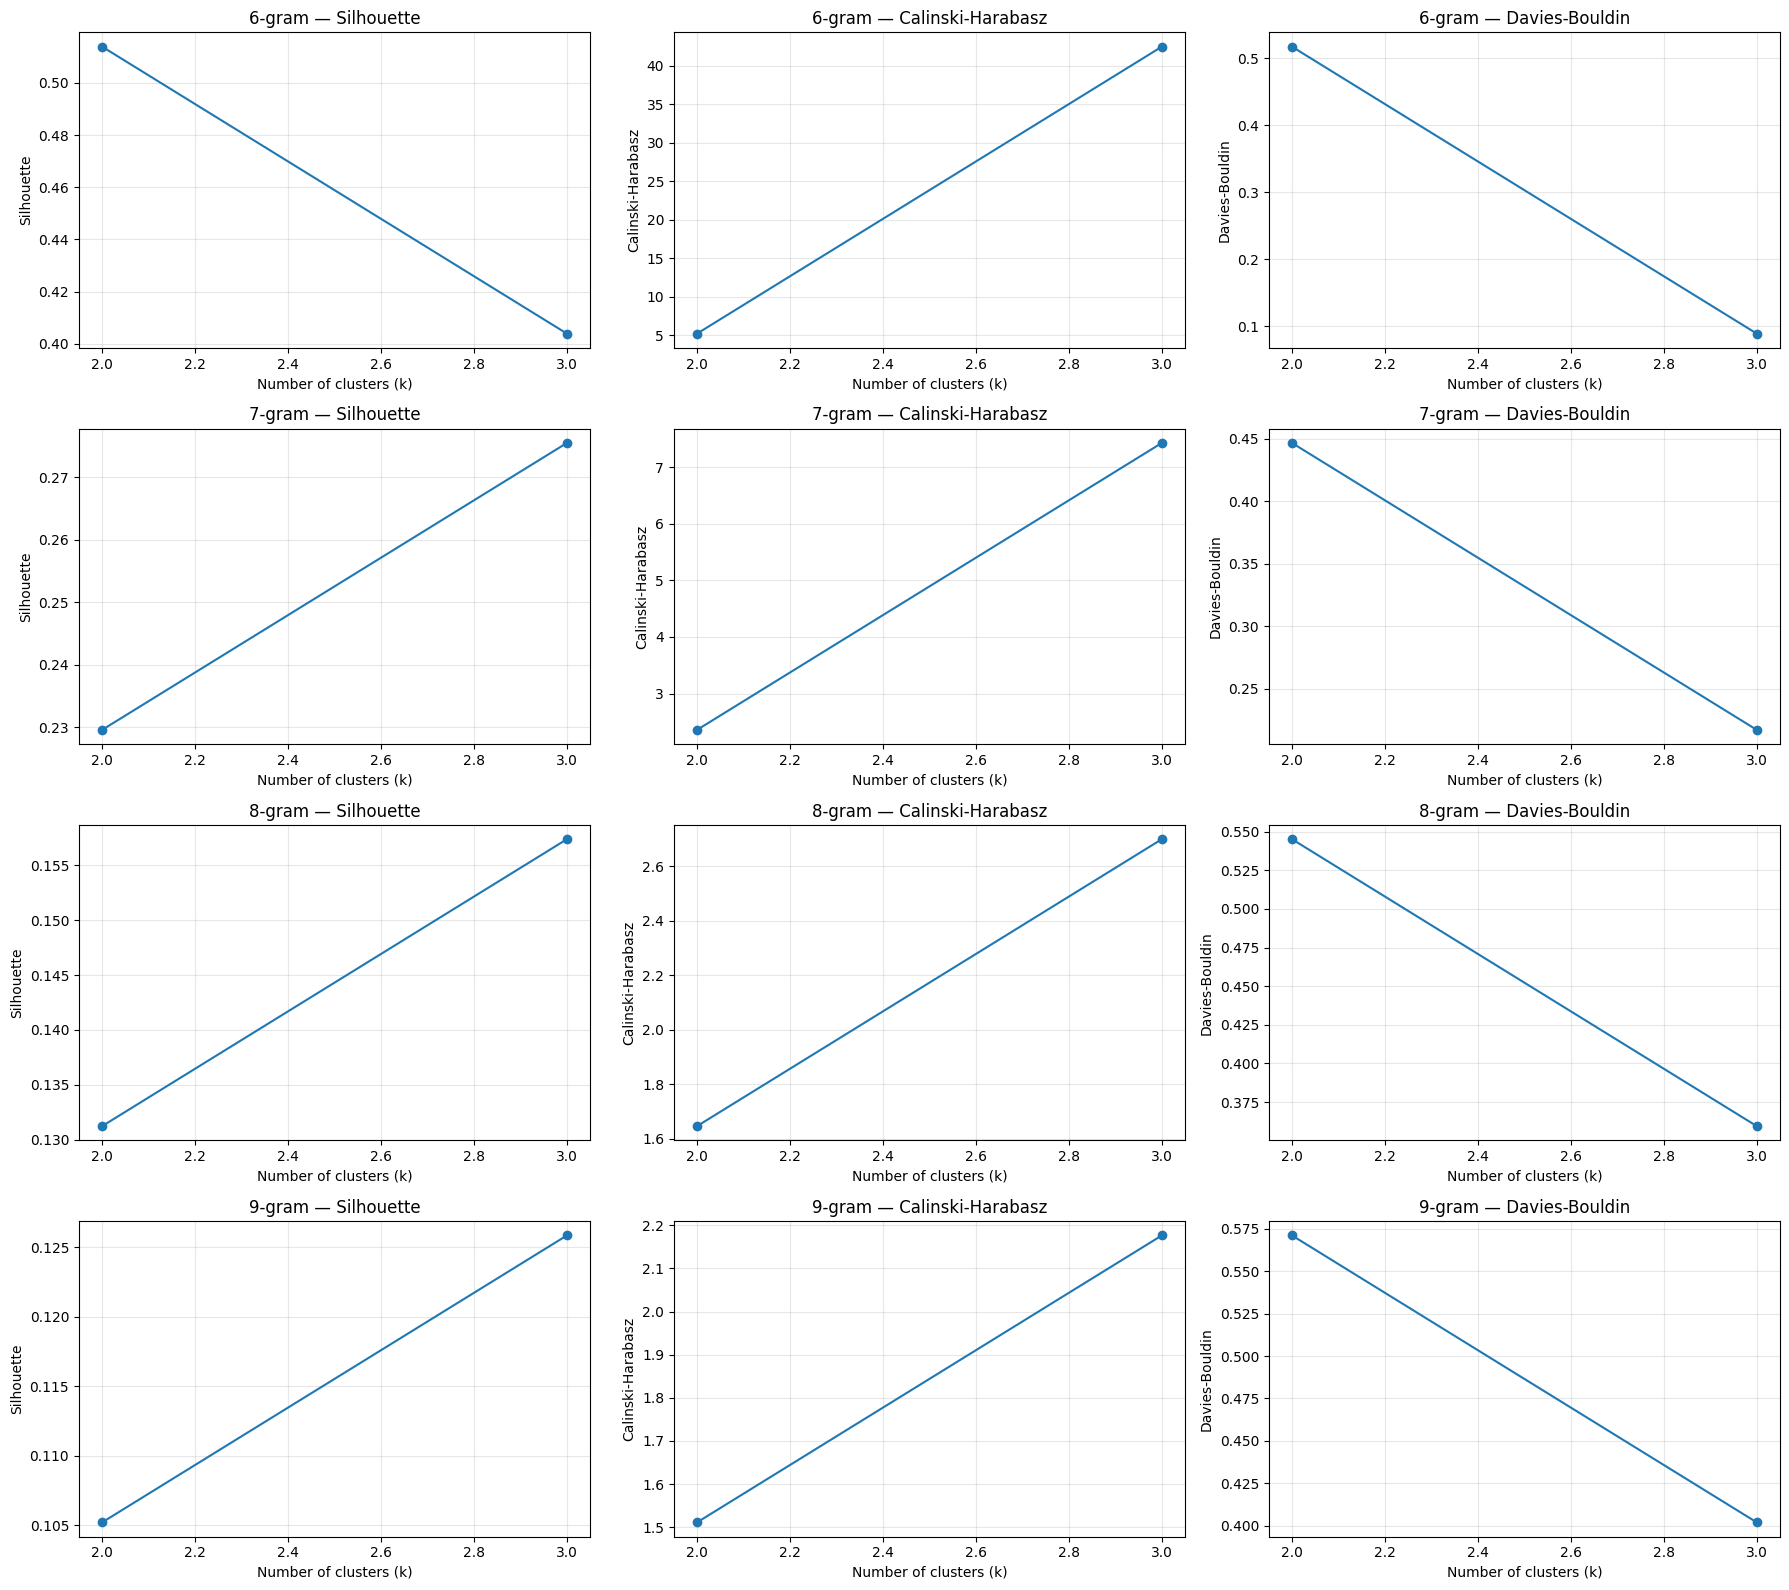

{'6-gram': {'clusters': [2, 3, 4],
  'silhouette': [0.5138586269725665, 0.4038598718325922, None],
  'calinski': [5.238973344151864, 42.449038877587604, None],
  'davies': [0.5172737496962458, 0.08874369321011029, None]},
 '7-gram': {'clusters': [2, 3, 4],
  'silhouette': [0.22961019579305453, 0.2754773011738925, None],
  'calinski': [2.357404192329478, 7.429486902993786, None],
  'davies': [0.4467548717343203, 0.21700966356537113, None]},
 '8-gram': {'clusters': [2, 3, 4],
  'silhouette': [0.1312356415673398, 0.15737570885400784, None],
  'calinski': [1.6456742956989572, 2.698627024914963, None],
  'davies': [0.545138448282387, 0.3594244854325724, None]},
 '9-gram': {'clusters': [2, 3, 4],
  'silhouette': [0.10519103847537342, 0.12584311628080375, None],
  'calinski': [1.511389181370749, 2.1764052552311823, None],
  'davies': [0.5711449143933023, 0.4018600914314417, None]}}

In [22]:
hierarchical_clustering(datasets)

In [35]:
from matplotlib import cm

def get_color_map_for_labels(datasets, cmap_name="tab20"):
    """
    Build a consistent color map for virus-type labels across all datasets.

    Input:
      datasets: dict {name: df}, df has 'ngram' + virus-type columns (counts)
    Returns:
      dict {virus_label -> RGBA color}
    """
    all_labels = []
    for name, df in datasets.items():
        # Drop CSV auto-index if present
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")

        virus_cols = [c for c in df.columns if c != "ngram"]
        all_labels.extend(virus_cols)

    unique_labels = sorted(set(all_labels))

    # Nova sintaksa za colormap u Matplotlib 3.7+
    base_cmap = cm.get_cmap(cmap_name)  # ili: plt.colormaps[cmap_name]
    if hasattr(base_cmap, "resampled"):  # ako želimo tačno n boja
        base_cmap = base_cmap.resampled(len(unique_labels))
    colors = [base_cmap(i) for i in range(len(unique_labels))]

    return dict(zip(unique_labels, colors))

In [31]:
def visualize_clusters_only(datasets, k=2, color_by="cluster"):
    """
    Visualize PCA(2D) of standardized, transposed data for each dataset.
    Overlays AgglomerativeClustering with k clusters and shows cluster centroids in PCA space.

    Args:
      datasets: dict {name: df} with 'ngram' + virus-type columns
      k: number of clusters for AgglomerativeClustering
      color_by: "cluster" (color by predicted cluster) or "virus" (color by true virus type)
    """
    # Global color maps:
    virus_cmap = get_color_map_for_labels(datasets)
    # Cluster colors: use new Matplotlib colormap API
    cluster_cmap = plt.colormaps["tab10"].resampled(k)

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))
    if n_plots == 1:
        axs = [axs]

    for ax, (name, df) in zip(axs, datasets.items()):
        # Clean/reshape
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")
        mat = df.set_index("ngram")
        mat_T = mat.T  # rows = virus types (samples)

        labels_true = mat_T.index.to_numpy()
        X = mat_T.values.astype(float)

        # Standardize, PCA
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xs = scaler.fit_transform(X)
        pca = PCA(n_components=2, random_state=42)
        Xp = pca.fit_transform(Xs)

        # Clustering in original standardized feature space
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        clusters = model.fit_predict(Xs)

        # Compute "centroids" in PCA space (mean of points in each cluster)
        centers = []
        for cid in range(k):
            pts = Xp[clusters == cid]
            centers.append(pts.mean(axis=0) if len(pts) else np.array([np.nan, np.nan]))
        centers = np.vstack(centers)

        # Choose coloring
        if color_by == "virus":
            point_colors = [virus_cmap.get(lbl, (0.5, 0.5, 0.5, 1.0)) for lbl in labels_true]
            title_suffix = "colored by virus type"
        else:
            point_colors = [cluster_cmap(c) for c in clusters]
            title_suffix = f"colored by cluster (k={k})"

        # Scatter PCA points
        ax.scatter(Xp[:, 0], Xp[:, 1], c=point_colors, s=80, edgecolor='k', linewidths=0.5)

        # Plot cluster centers
        ax.scatter(centers[:, 0], centers[:, 1],
                   marker='x', c='black', s=150, linewidths=3, label='Cluster centroid')

        ax.set_title(f"{name} — {title_suffix}", fontsize=13)
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.set_aspect('equal')

        # Optional legends (kept compact)
        if color_by == "virus":
            # show up to 12 labels to avoid clutter
            uniq = sorted(set(labels_true))[:12]
            from matplotlib.lines import Line2D
            handles = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=virus_cmap.get(l, (0.5, 0.5, 0.5, 1.0)),
                              markeredgecolor='k', markersize=8, label=l)
                       for l in uniq]
            if handles:
                ax.legend(handles=handles, title="virus_type", bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            # cluster legend
            from matplotlib.lines import Line2D
            handles = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=cluster_cmap(c),
                              markeredgecolor='k', markersize=8, label=f"Cluster {c}")
                       for c in range(k)]
            handles.append(Line2D([0], [0], marker='x', color='k', linewidth=3, label='Cluster centroid'))
            ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [33]:
def draw_legend_for_labels(datasets, ncol=4):
    """
    Draw a compact legend for virus-type labels using the global color map.
    """
    # Dobijamo boje iz novog colormap API-ja
    color_map = get_color_map_for_labels(datasets)
    unique_labels = list(color_map.keys())
    colors = list(color_map.values())

    n_rows = int(np.ceil(len(unique_labels) / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    # Pravimo patch-e za legendu
    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=colors[i], label=unique_labels[i])
               for i in range(len(unique_labels))]
    ax.legend(handles=handles,
              loc='upper center',
              bbox_to_anchor=(0.5, 1.0),
              fontsize=10,
              ncol=ncol,
              frameon=False)

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()


/tmp/ipykernel_12054/3629428944.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap(cmap_name)  # ili: plt.colormaps[cmap_name]


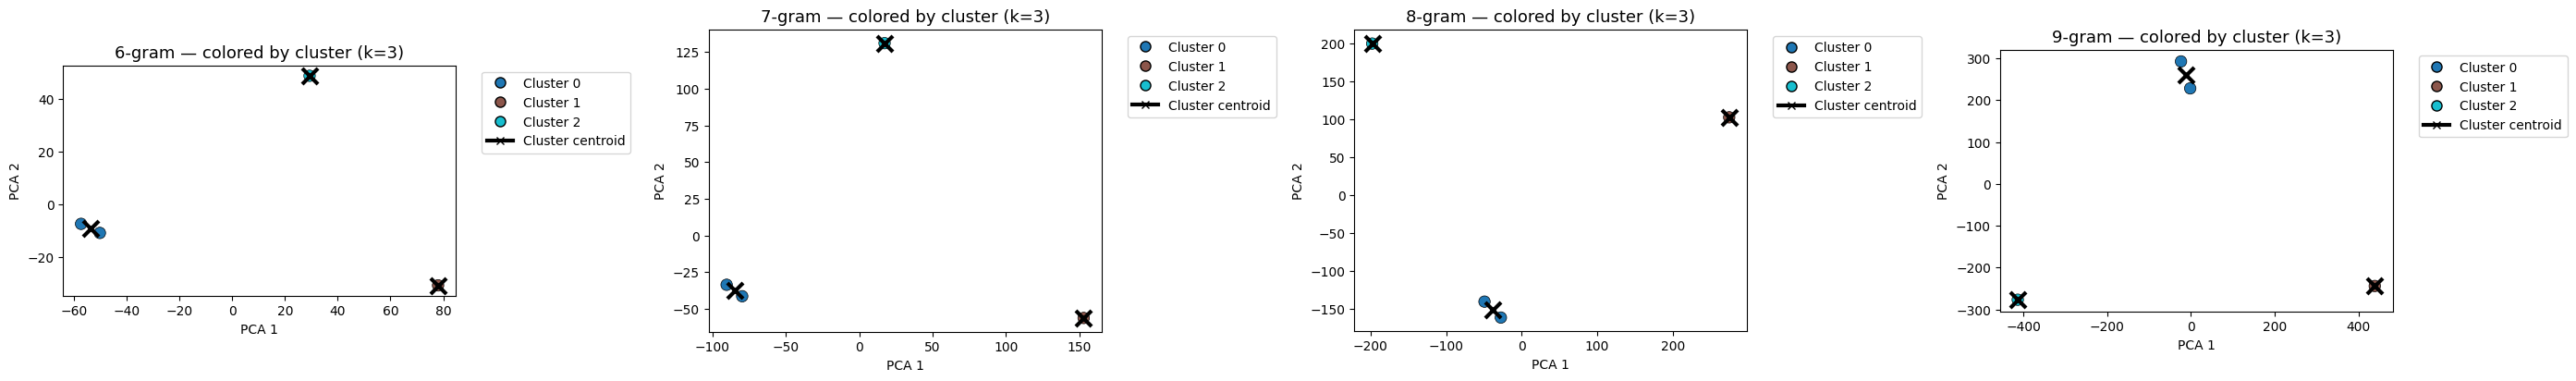

/tmp/ipykernel_12054/3629428944.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap(cmap_name)  # ili: plt.colormaps[cmap_name]


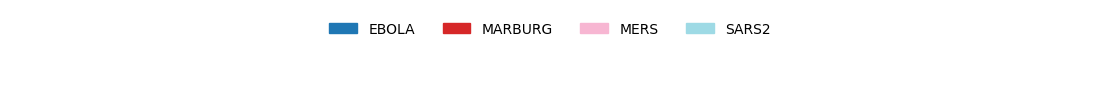

In [36]:
visualize_clusters_only(datasets, k=3)
draw_legend_for_labels(datasets)

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def plot_dendrograms_simplified(datasets, p_levels=6):
    """
    For each dataset, compute a Ward linkage dendrogram on standardized, transposed data:
      - samples = virus types, features = n-grams
      - Ward requires euclidean distances on standardized data
    """
    n_plots = len(datasets)
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 5 * n_plots))
    if n_plots == 1:
        axs = [axs]

    for ax, (name, df) in zip(axs, datasets.items()):
        # Clean/reshape
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")
        mat = df.set_index("ngram")
        mat_T = mat.T

        # Standardize
        X = mat_T.values.astype(float)
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xs = scaler.fit_transform(X)

        # Ward linkage on standardized features
        Z = linkage(Xs, method='ward')

        dendrogram(
            Z,
            ax=ax,
            truncate_mode='level',
            p=p_levels,
            labels=mat_T.index.tolist(),  # virus type names on leaves (may be truncated)
            leaf_rotation=90,
            leaf_font_size=8,
            show_contracted=True,
            show_leaf_counts=True,
            distance_sort='descending'
        )
        ax.set_title(f"Simplified Dendrogram — {name}", fontsize=14)
        ax.set_ylabel("Ward distance")

    plt.tight_layout()
    plt.show()

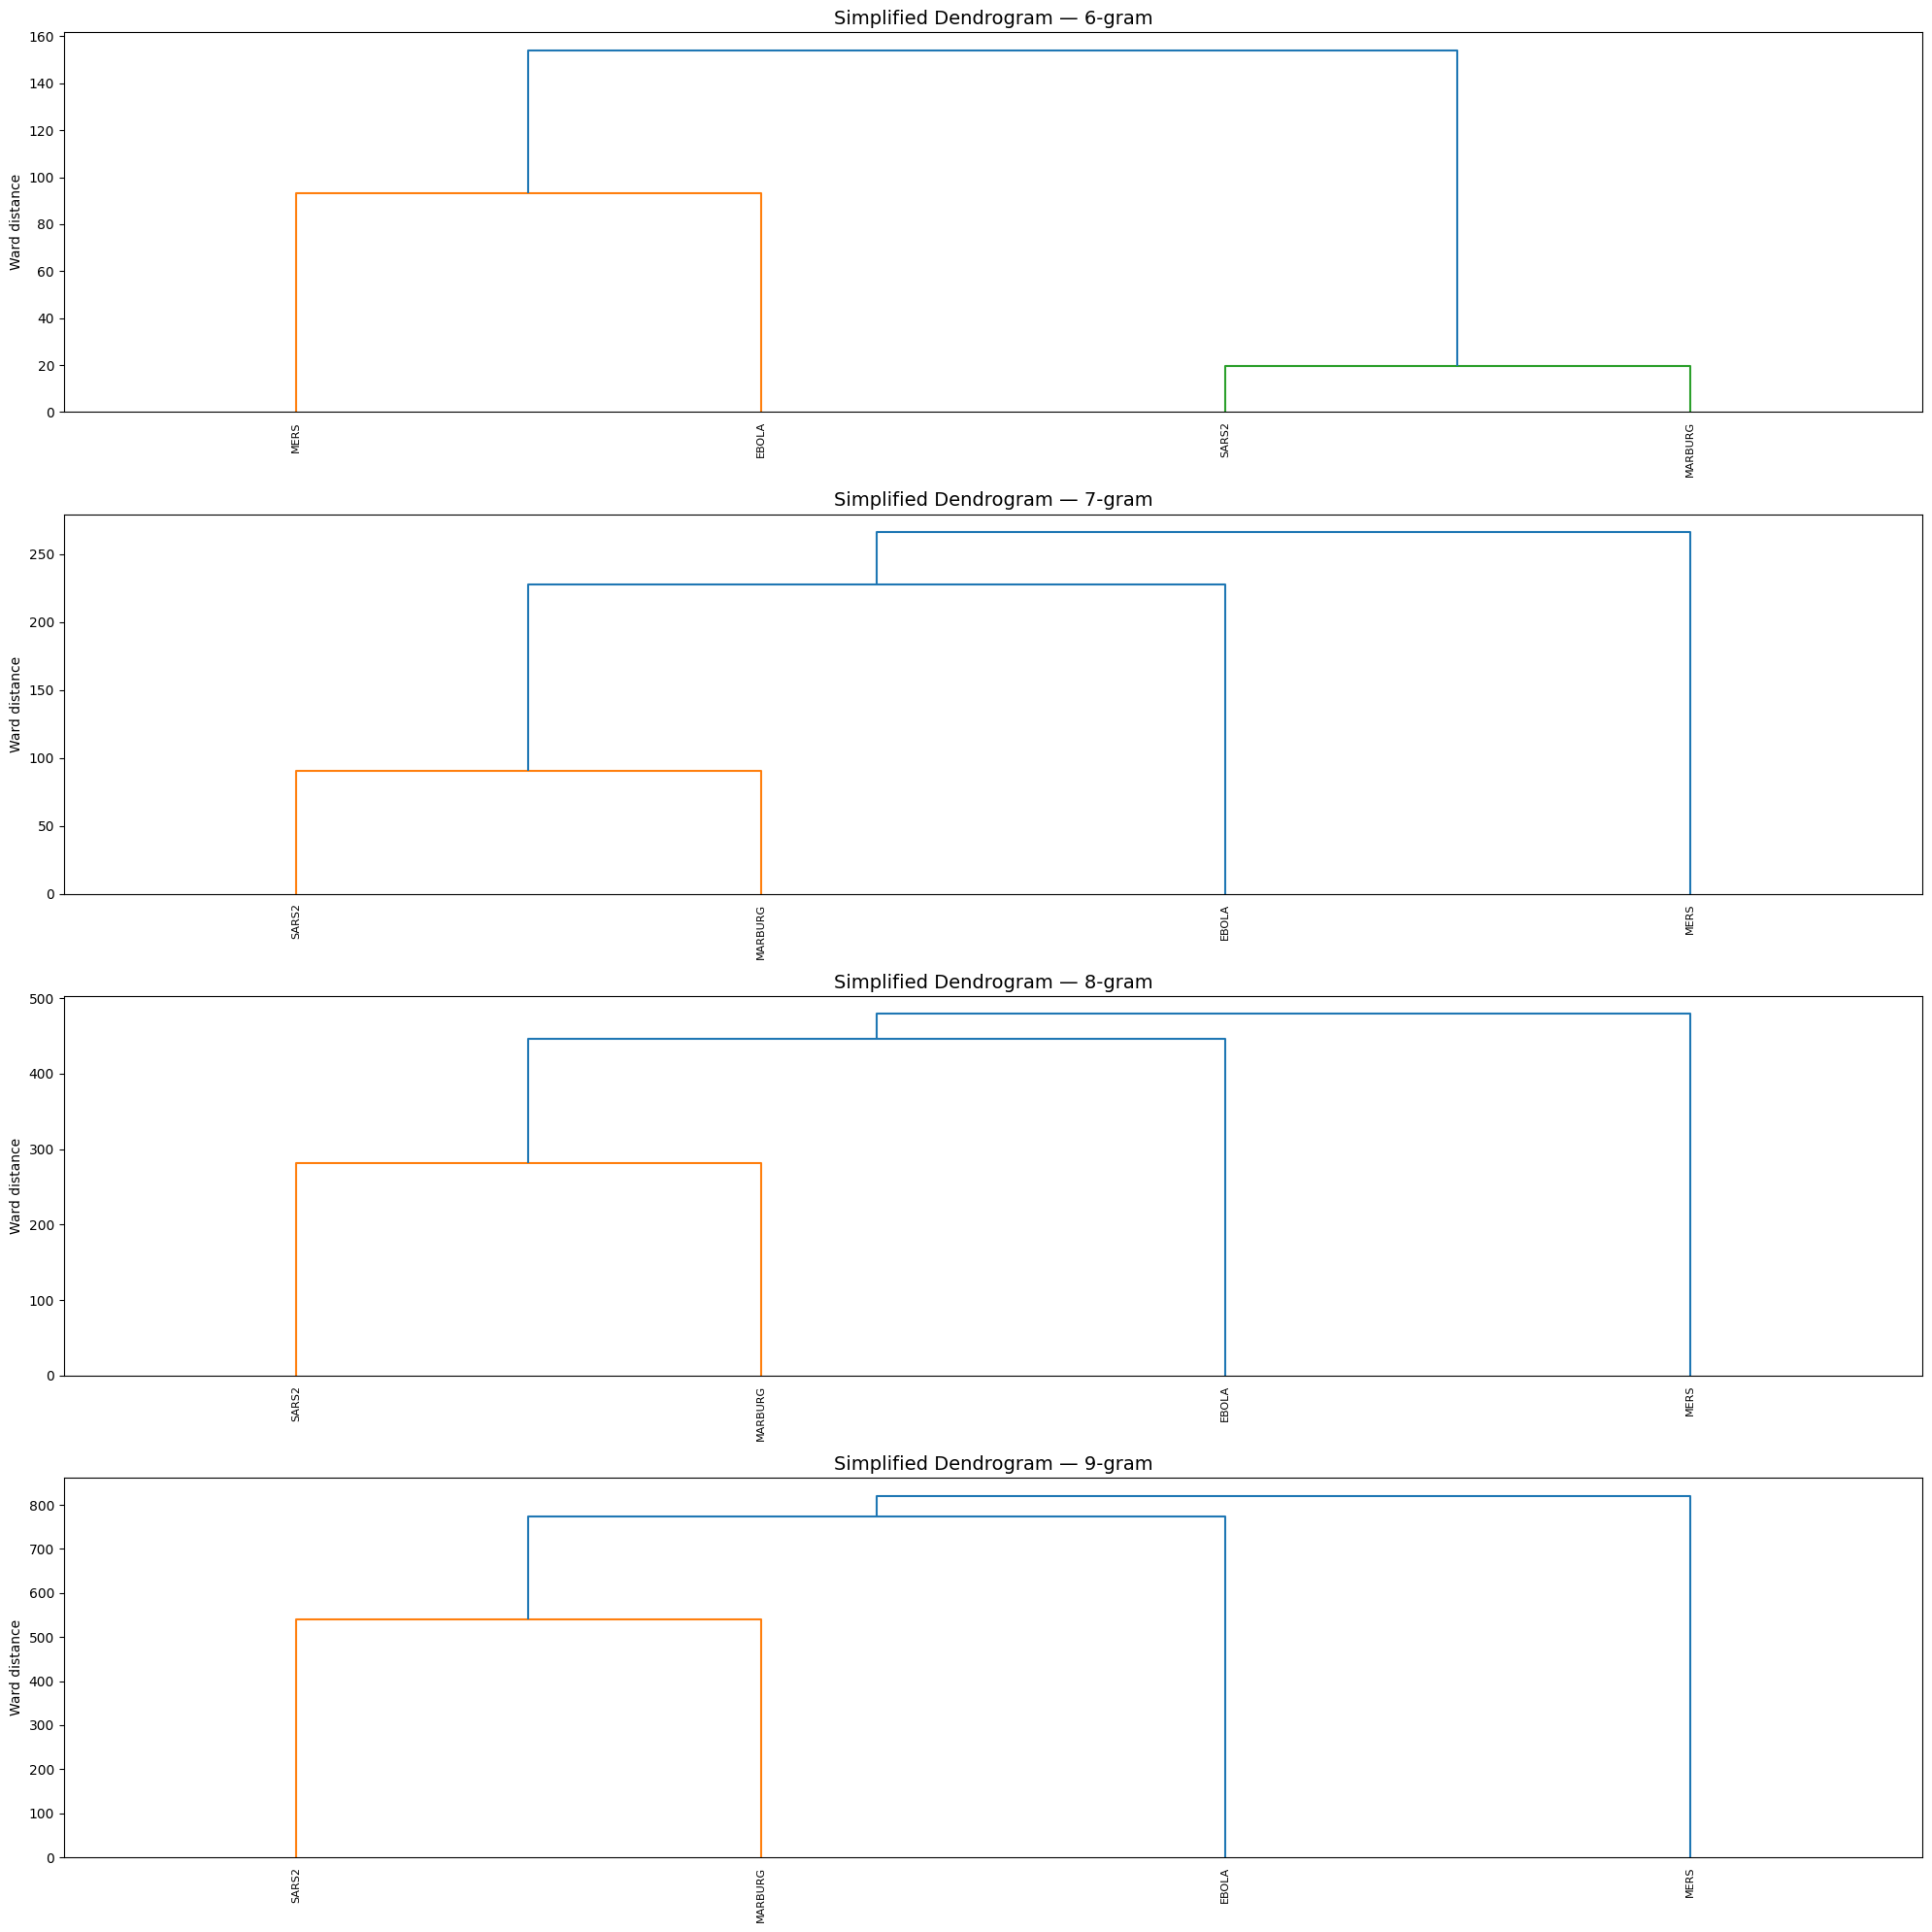

In [30]:
plot_dendrograms_simplified(datasets)

# SOM

In [1]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
def som(datasets, som_x=15, som_y=15, iterations=1000):
    """
    Train and visualize SOMs for vertical n-gram matrices.

    Expected input: dict {dataset_name: df}, where df has column 'ngram' + one column per virus type.
    Example DF:
        ngram   VirusA  VirusB  VirusC
        AAA     10      3       0
        AAC     2       7       1
        ...
    """
    results = []
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 5 * len(datasets)))

    if len(datasets) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (name, df) in enumerate(datasets.items()):
        # Drop unwanted columns like 'Unnamed: 0' if present
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])

        # Check for 'ngram' column
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must have a column 'ngram'.")

        # Set 'ngram' as index and transpose so samples = virus types
        mat = df.set_index("ngram")
        mat_T = mat.T

        # Labels are virus types (index after transpose)
        labels = mat_T.index.to_numpy()
        features = mat_T.values.astype(float)

        # Standardize features across n-grams
        scaler = StandardScaler(with_mean=True, with_std=True)
        features_scaled = scaler.fit_transform(features)

        # Train SOM
        som = MiniSom(x=som_x, y=som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
        som.random_weights_init(features_scaled)
        som.train_random(features_scaled, num_iteration=iterations)

        # BMU coordinates for each sample
        bmu_coords = np.array([som.winner(x) for x in features_scaled])

        # Map virus labels to integers for coloring
        unique_labels = list(labels)
        label_to_int = {lab: idx for idx, lab in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[lab] for lab in labels])

        # Save results
        results.append({
            "dataset": name,
            "n_viruses": len(labels),
            "n_features": features_scaled.shape[1],
            "n_clusters": len(np.unique(bmu_coords, axis=0))
        })

        # Plot U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({name})")
        im = ax1.pcolor(som.distance_map().T, cmap='bone_r')
        fig.colorbar(im, ax=ax1)

        # Plot SOM map colored by virus type
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM colored by virus_type ({name})")
        scatter = ax2.scatter(
            bmu_coords[:, 0], bmu_coords[:, 1],
            c=color_labels, cmap='tab10',
            s=60, edgecolors='k', linewidths=0.5
        )
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)

        handles, _ = scatter.legend_elements()
        ax2.legend(
            handles=handles,
            labels=unique_labels,
            title="virus_type",
            bbox_to_anchor=(1.05, 1), loc='upper left'
        )

    plt.tight_layout()
    plt.show()

    return results


In [9]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

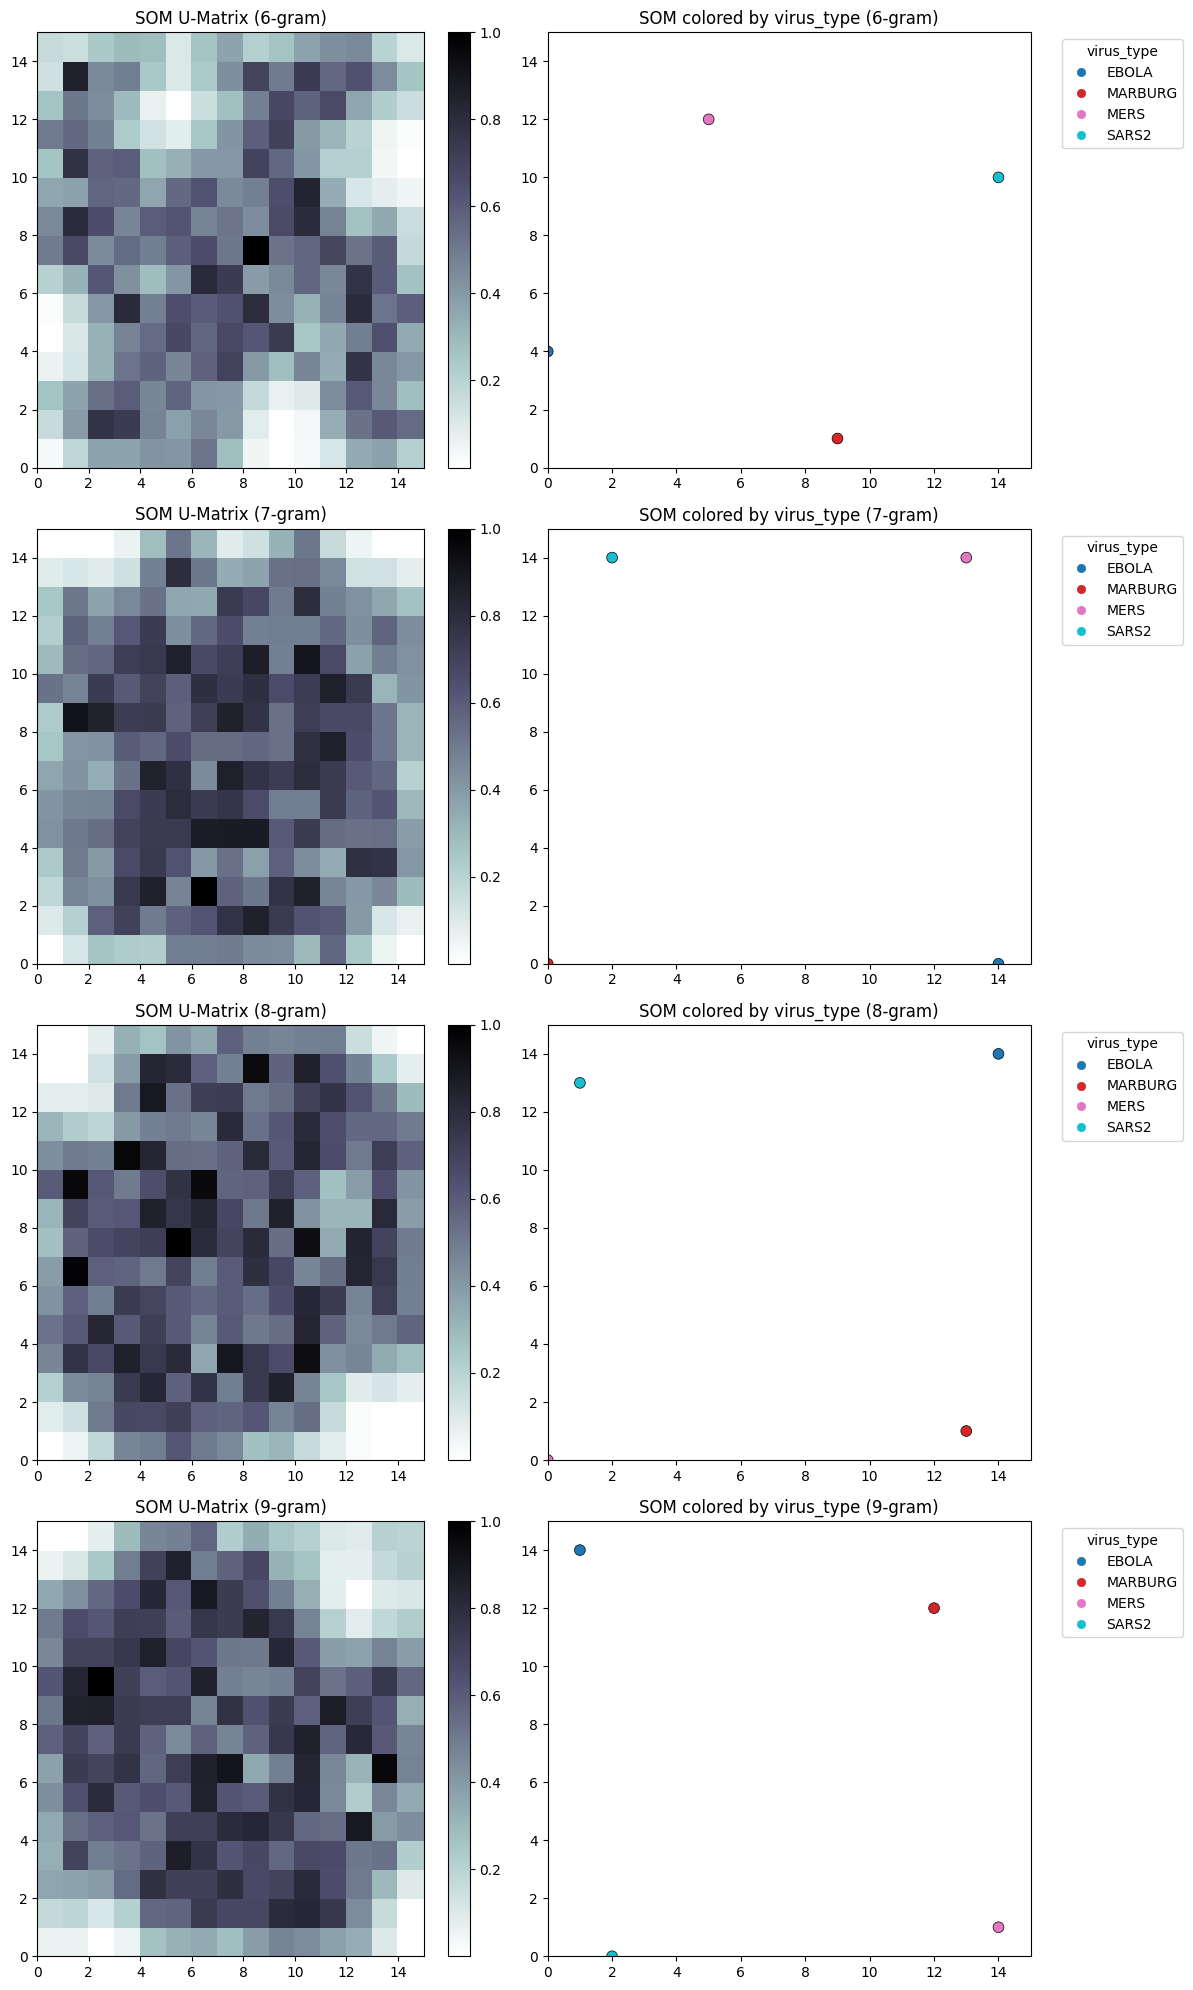

[{'dataset': '6-gram', 'n_viruses': 4, 'n_features': 4096, 'n_clusters': 4},
 {'dataset': '7-gram', 'n_viruses': 4, 'n_features': 16377, 'n_clusters': 4},
 {'dataset': '8-gram', 'n_viruses': 4, 'n_features': 63495, 'n_clusters': 4},
 {'dataset': '9-gram', 'n_viruses': 4, 'n_features': 195546, 'n_clusters': 4}]

In [10]:
som(datasets, som_x=15, som_y=15, iterations=1000)